In [1]:
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def block_divide(image, block_size):
    h, w = image.shape
    h_blocks = h // block_size
    w_blocks = w // block_size
    blocks = np.zeros((h_blocks, w_blocks, block_size, block_size))

    for i in range(h_blocks):
        for j in range(w_blocks):
            blocks[i, j] = image[i * block_size: (i + 1) * block_size,
                                  j * block_size: (j + 1) * block_size]
    return blocks

In [3]:
def dct(block):
    return fftpack.dct(fftpack.dct(block, axis=0, norm='ortho'), axis=1, norm='ortho')

In [4]:
def quantize(block, quantization_matrix):
    return np.round(block / quantization_matrix)

In [5]:
def inverse_quantize(quantized_block, quantization_matrix):
    return quantized_block * quantization_matrix

In [6]:
def idct(block):
    return fftpack.idct(fftpack.idct(block, axis=0, norm='ortho'), axis=1, norm='ortho')

In [7]:
def jpeg_compression(image, block_size, quantization_matrix):
    h, w = image.shape
    compressed_image = np.zeros_like(image)
    h_blocks = h // block_size
    w_blocks = w // block_size

    for i in range(h_blocks):
        for j in range(w_blocks):
            block = image[i * block_size: (i + 1) * block_size,
                          j * block_size: (j + 1) * block_size]
            dct_block = dct(block - 128)
            quantized_block = quantize(dct_block, quantization_matrix)
            compressed_block = inverse_quantize(quantized_block, quantization_matrix)
            compressed_block = idct(compressed_block) + 128
            compressed_image[i * block_size: (i + 1) * block_size,
                             j * block_size: (j + 1) * block_size] = compressed_block

    return compressed_image

In [8]:
def ssim(image1, image2):
    mean1 = np.mean(image1)
    mean2 = np.mean(image2)
    std1 = np.std(image1)
    std2 = np.std(image2)
    covar = np.cov(image1.flatten(), image2.flatten())[0, 1]

    c1 = (0.01 * 255) ** 2
    c2 = (0.03 * 255) ** 2

    ssim = ((2 * mean1 * mean2 + c1) * (2 * covar + c2)) / ((mean1 ** 2 + mean2 ** 2 + c1) * (std1 ** 2 + std2 ** 2 + c2))
    return ssim

SSIM for red channel: 0.9910
SSIM for green channel: 0.9991
SSIM for blue channel: 0.9985


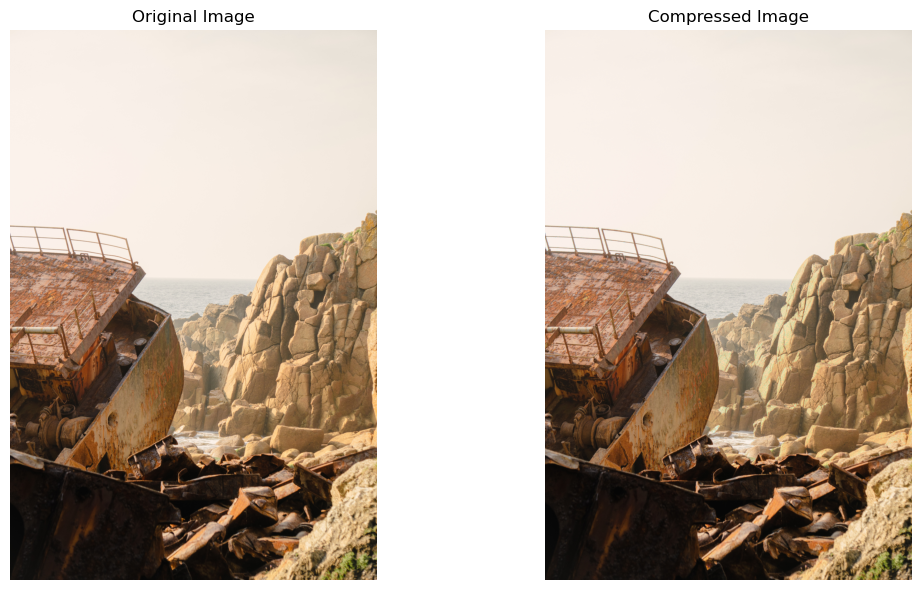

In [11]:
# Load the image
image_path = 'HQ.jpg'  # Replace with your image path
image = np.array(Image.open(image_path))

# Parameters
block_size = 8
quantization_matrix = np.array([[6, 4, 4, 6, 10, 16, 20, 24],
                                [5, 5, 6, 8, 10, 23, 24, 22],
                                [6, 5, 6, 10, 16, 23, 28, 22],
                                [6, 7, 9, 12, 20, 35, 32, 25],
                                [7, 9, 15, 22, 27, 44, 41, 31],
                                [10, 14, 22, 26, 32, 42, 45, 37],
                                [20, 26, 31, 35, 41, 48, 48, 40],
                                [29, 37, 38, 39, 45, 40, 41, 40]])  # Define your quantization matrix here

# Separate color channels
red_channel = image[:, :, 0]
green_channel = image[:, :, 1]
blue_channel = image[:, :, 2]

# Perform JPEG compression for each channel
compressed_red_channel = jpeg_compression(red_channel, block_size, quantization_matrix)
compressed_green_channel = jpeg_compression(green_channel, block_size, quantization_matrix)
compressed_blue_channel = jpeg_compression(blue_channel, block_size, quantization_matrix)

# Merge compressed color channels
compressed_image = np.stack((compressed_red_channel, compressed_green_channel, compressed_blue_channel), axis=-1)

# Calculate SSIM for each channel
ssim_red = ssim(red_channel, compressed_red_channel)
ssim_green = ssim(green_channel, compressed_green_channel)
ssim_blue = ssim(blue_channel, compressed_blue_channel)

print(f"SSIM for red channel: {ssim_red:.4f}")
print(f"SSIM for green channel: {ssim_green:.4f}")
print(f"SSIM for blue channel: {ssim_blue:.4f}")

# Plot the original and compressed images side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(compressed_image)
plt.title('Compressed Image')
plt.axis('off')

plt.tight_layout()
plt.show()